# ENERGY BASE MODELS (EBM)

## Imports

In [1]:
from tensorflow.keras import (
    datasets,
    layers,
    activations,
    models,
    metrics,
    optimizers,
    callbacks
)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
from pathlib import Path

2024-11-14 23:44:40.583303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 23:44:40.611651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 23:44:40.611691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 23:44:40.612875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 23:44:40.618611: I tensorflow/core/platform/cpu_feature_gua

## Functions

In [2]:
def preprocess_img(imgs):
    imgs= (imgs.astype('float32') - 127.5) / 127.5

    # (0,0) - means do not change number of images in the batch
    # (2,2),(2,2) - means create a frame thick=2
    # constant_values - means fill fram with -1.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=-1.0 )
    imgs = np.expand_dims(imgs, -1)

    return imgs

def sample_batch(dataset):
    batch= dataset.take(1).get_single_element()

    if isinstance(batch, tuple):
        batch= batch[0]

    return batch.numpy()


def display_mnist_img_tf(img_tf):

    if img_tf.max() > 1.0:
        img_tf= img_tf / 255.0
    elif img_tf.min() < 0.0:
        img_tf= (img_tf + 1.0) / 2.0
        
    plt.figure(figsize=(3,3))
    plt.imshow(img_tf[0].astype('float32'))
    plt.axis('off')
    plt.show()

def display_img(images, n=1, fig_size=(20,3), c_map='gray_r', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path=Path(save_to)
        oPath=Path(oFull_path.parent)

        if not oPath.exists():
            oPath.mkdir(parents=True, exist_ok=True)

    if images.max() > 1.0:
        images=images/255.0
    elif images.min() < 0.0:
        images=(images+1.0)/2.0

    plt.figure(figsize=fig_size)
    for i in range(n):
        _=plt.subplot(1,n,i+1)
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')
        plt.show()
        
    if save_to:
        plt.savefig(save_to)

## LOAD AND PRE-PROCESS DATA

2024-11-14 23:44:43.084556: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 23:44:43.112986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 23:44:43.113040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 23:44:43.117463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 23:44:43.117520: I external/local_xla/xla/stream_executor

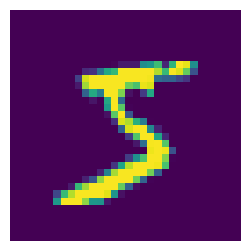

CPU times: user 709 ms, sys: 315 ms, total: 1.02 s
Wall time: 1.12 s


In [3]:
%%time
batch_size= 128

(x_train, _), (x_test, _) = datasets.mnist.load_data()

x_train= preprocess_img(x_train)
x_test= preprocess_img(x_test)

x_train= tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
x_test= tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

display_mnist_img_tf(sample_batch(x_train))

## EBM

### NN Architecture

In [4]:
img_size= 32
ch_n= 1

ebm_input= layers.Input(
    shape=(img_size, img_size, ch_n)
)

x= layers.Conv2D(
    16,
    kernel_size=5,
    strides=2,
    padding='same',
    activation= activations.swish
)(ebm_input)

x= layers.Conv2D(
    32,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)
x= layers.Conv2D(
    64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)
x= layers.Conv2D(
    64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)

x= layers.Flatten()(x)
x= layers.Dense(
    64,
    activation= activations.swish
)(x)

ebm_output= layers.Dense(1)(x)

model= models.Model(ebm_input, ebm_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

### Langevin

In [5]:
def generate_samples(model, in_imgs, steps, step_size, noise, return_img_per_step=False):
    imgs_per_step= []

    for _ in range(steps):
        in_imgs += tf.random.normal(in_imgs.shape, mean=0, stddev=noise)
        in_imgs = tf.clip_by_value(in_imgs, -1.0, 1.0)

        with tf.GradientTape() as tape:
            tape.watch(in_imgs)
            out_score= model(in_imgs)

        grads= tape.gradient(out_score, in_imgs)
        grads= tf.clip_by_value(in_imgs, -1.0, 1.0)

        if return_img_per_step:
            imgs_per_step.append(in_imgs)
            
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return in_imgs

### Buffer

In [6]:
buffer_size= 8192

class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model=model
        self.examples= [
            tf.random.uniform(shape=(1, img_size, img_size, ch_n)) * 2 -1 for _ in range(batch_size)
        ]

    def sample_new_examples(self, steps, step_size, noise):
        n_new= np.random.binomial(batch_size, 0.05)
        
        random_imgs= (
            tf.random.uniform(
                (
                    n_new, 
                    img_size, 
                    img_size, 
                    ch_n
                )
            ) * 2 -1)
        
        old_imgs= tf.concat(
            random.choices(
                self.examples, 
                k=batch_size - n_new
            ), axis=0)
        
        inp_imgs= tf.concat(
            [
                random_imgs, 
                old_imgs
            ], axis=0)
        
        inp_imgs= generate_samples(
            self.model, 
            inp_imgs,
            steps=steps,
            step_size=step_size,
            noise=noise
        )

        self.examples= tf.split(
            inp_imgs,
            batch_size,
            axis=0
        ) + self.examples

        self.examples= self.examples[:buffer_size]

        return inp_imgs
        

### Model

In [7]:
noise= 5e-3
steps=60
step_size= 10

class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model= model
        self.buffer= Buffer(self.model)
        self.alpha= .1
        self.loss_metric= metrics.Mean(name='loss')
        self.reg_loss_metric= metrics.Mean(name='reg')
        self.cdiv_loss_metric= metrics.Mean(name='cdiv')
        self.real_out_metric= metrics.Mean(name='real')
        self.fake_out_metric= metrics.Mean(name='fake')

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean=0, stddev=noise)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_examples(steps=steps, step_size=step_size, noise=noise)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)

        with tf.GradientTape() as tape:
            real_out, fake_out= tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
            reg_loss= self.alpha * tf.reduce_mean(real_out**2 + fake_out**2, axis=0)
            loss= cdiv_loss + reg_loss

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return { m.name: m.result() for m in self.metrics }

    def test_step(self, real_imgs):
        batch_size= real_imgs.shape[0]
        fake_imgs= tf.random.uniform((batch_size, img_size, img_size, ch_n)) *2 -1
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out= tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv= tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics[2:]}
        

In [8]:
ebm = EBM()

In [9]:
learning_rate= 5e-4

ebm.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    run_eagerly=True
)

In [10]:
log_dir='./logs/ebm/mnist/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard_callback= callbacks.TensorBoard(log_dir=log_dir)

In [11]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, save_to):
        self.num_img=num_img
        self.save_to=save_to

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, img_size, img_size, ch_n)
            )
            * 2
            - 1
        )
        generated_images= generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=step_size,
            noise=noise,
            return_img_per_step=False
        )
        generated_images= generated_images.numpy()
        export_path=self.save_to + '/generated_img%03d.png' % (epoch)
        
        display_img(
            generated_images,
            c_map=None,
            save_to=export_path            
        )
        
        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        
        example_images = example_images.numpy()
        export_path=self.save_to + '/example_img_%03d.png' % (epoch)
        
        display_img(
            example_images,
            c_map=None,
            save_to=export_path            
        )
        

image_generator_callback=ImageGenerator(num_img=10, save_to=log_dir + '/images')

Epoch 1/60


2024-11-14 23:44:45.214833: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


469/469 ━━━━━━━━━━━━━━━━━━━━ 818s 2s/step - cdiv: -7.9261 - fake: -3.6566 - loss: -4.0057 - real: 4.2695 - reg: 3.9204 - val_cdiv: -9.6705 - val_real: 4.9405 - val_fake: -4.7300
Epoch 2/60
121/469 ━━━━━━━━━━━━━━━━━━━━ 9:02 2s/step - cdiv: -9.9152 - fake: -4.9264 - loss: -4.9878 - real: 4.9888 - reg: 4.9274

KeyboardInterrupt: 

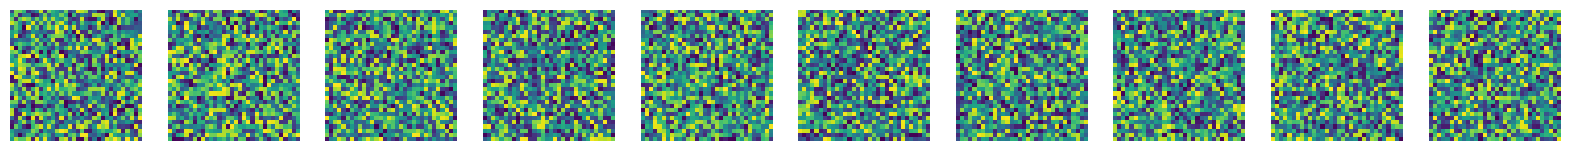

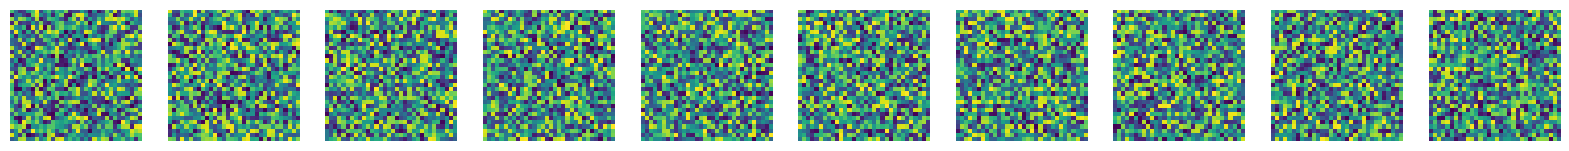

In [12]:
x_test_r = x_test.take(1)
x_train_r = x_train.take(1)
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        tensorboard_callback,
        image_generator_callback
    ]
)